In [1]:
import numpy as np
import matplotlib.pyplot as plt
from casadi import *

In [4]:
# Hyperparameters
test_results = True
T = 10 # Time horizon
N = 20 # Number of control intervals

Initialize states, inputs, and system dynamic equation

In [5]:
# States
x1 = MX.sym('x1')
x2 = MX.sym('x2')
x = vertcat(x1,x2) # Always vertically concatenate the states --> [n_x,1]
# Inputs
u1 = MX.sym('u')
u = vertcat(u1) # Always vertically concatenate the inputs --> [n_u,1]
# System dynamics (CAN BE NONLINEAR! ;))
f1 = (1-x2**2)*x1 -x2 + u1
f2 = x1
ode = vertcat(f1,f2) # ORDINARY DIFFERENTIAL EQUATION: Always vertically concatenate dynamic equations --> [n_x,1]
f = Function('f',[x,u],[ode],['x','u'],['ode'])
if test_results:
    print(f([0.2, 0.8], 0.1))

[-0.628, 0.2]


Define the integrator to discretize the system

In [16]:
# Integrator to discretize the ordinary differential equation --> differential algebraic equation
intg_options = dict()
intg_options['tf'] = T/N
intg_options['simplify'] = True
intg_options['number_of_finite_elements'] = 4
# DAE problem structure
dae = dict()
dae['x'] = x    # Variables 
dae['p'] = u    # Parameters (N.B. for an MPC, the inputs are passed to DAE as parameters)
dae['ode'] = f(x,u) # Expression in continuos time

intg = integrator('intg','rk', dae, intg_options) # Runge-Kutta

if test_results: # To numerically evaluate the DAE
    res = intg(x0=[0,1],p=0)
    print(res['xf'])

# For the system dynamics, we need the symbolic DAE to update system state
res = intg(x0=x, p=u) 
x_next = res['xf'] # Access x_next as the DAE symbolic solution

# Define function F to simplify mapping between symbolic (x,u) --> (x_next)
F = Function('F',[x,u],[x_next],['x','u'],['x_next'])

[-0.494017, 0.876098]


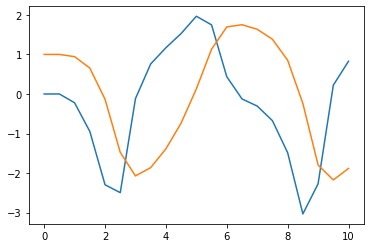

In [17]:
# Test the problem definition
sim = F.mapaccum(N) # To call the F function N times
x0 = [0,1]
res = sim(x0, np.cos(np.arange(N))) # Example: u1 = cosine excitation
fig = plt.figure()
tgrid = np.linspace(0,T,N+1)
plt.plot(tgrid, np.column_stack((x0, res)).T)

In [181]:
from scipy.sparse import csc_matrix
U = MX.sym('U',1,N)
X1 = sim(x0,U)[0,:]
J = jacobian(X1,U)

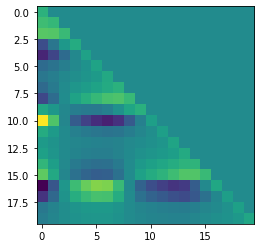

In [182]:
Jf = Function('Jf',[U],[J])
plt.imshow(Jf(0))

MESSAGE(sqpmethod): Convergence achieved after 4 iterations


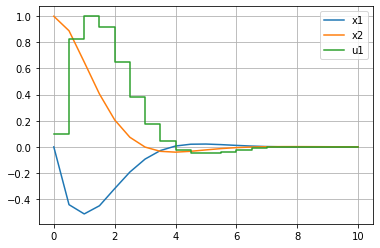

In [30]:
opti = Opti() # Special CasADi stack for optimization

x = opti.variable(2,N+1)    # States with dimension (n_x, prediction_horizon+1) (x(0),...,x(N+1))
u = opti.variable(1,N)      # Inputs with dimension (n_u, prediction_horizon) (u(0),...,u(N))
p = opti.parameter(2,1)     # Parameter to set the initial state conditions (x(0))

obj = sumsqr(x)+sumsqr(u)   # Objective function: (NOT NECESSARILY quadratic!)

opti.minimize(obj)          # Setup the problem 

# Constraints Definition

# 1) System dynamics constraint over the prediction horizon
for k in range(0,N):
    opti.subject_to(x[:,k+1]==F(x[:,k],u[:,k])) # System dynamics is called through F, that we defined above as the DAE that maps (x,u) --> (x,next)
    
# 2) Additional states/inputs constraints 
opti.subject_to(u<=1)        
opti.subject_to(u>=-1)
# 3) Force the state variable at instant 0 to be equal to the parameter value containing x0 value
opti.subject_to(x[:,0]==p)

opti.set_value(p,[0, 1]) # Set the initial x0 value

# Set additional options
opts = dict()
opts["qpsol"] = "qrqp" # Solver! See the docs for information
opts["print_header"] = False
opts["print_iteration"] = False
opts["print_time"] = False
opts["qpsol_options"] = dict({"print_iter":False,"print_header":False,"print_info":False})
opti.solver("sqpmethod", opts)

# If you want to test over 1 time horizon
if test_results:
    sol = opti.solve() # For testing purpose: test the optimization on 1 time step
    fig = plt.figure
    plt.plot(tgrid, sol.value(x[0,:]).T, label='x1')
    plt.plot(tgrid, sol.value(x[1,:]).T, label='x2')
    plt.plot(tgrid, np.column_stack((sol.value(u).reshape(1,-1), np.NaN)).T, drawstyle='steps-post', label='u1')
    plt.grid(True)
    plt.legend()

Final Step: run the MPC control loop!
N.B. Given that we want to simulate the system, e.g., 50 timesteps,
1. at each time step the previosly defined optimization problem computes inputs u and predicted states x in the prediction horizon N.
2. from computed sequence of inputs (u(0), ..., u(T)), ONLY u(0) value is selected to simulate the system
3. (x0, u(0)) --> x_next == x(1)
4. the loop restart

In [32]:
# This instruction transfom all the Opti problem defined above into a callable function
M = opti.to_function('M',[p],[u[:,0]],['p'],['u_opt'])

In [33]:
# MPC loop
X_log = np.empty((2,0))
U_log = np.array([])

x = [0,1]
for i in range(4*N):
    u = M(x)

    U_log = np.append(U_log, u)
    X_log = np.column_stack((X_log, x))

    # simulate
    x = F(x,u) + [0, np.random.rand()*0.02]

MESSAGE(sqpmethod): Convergence achieved after 4 iterations
MESSAGE(sqpmethod): Convergence achieved after 4 iterations
MESSAGE(sqpmethod): Convergence achieved after 4 iterations
MESSAGE(sqpmethod): Convergence achieved after 3 iterations
MESSAGE(sqpmethod): Convergence achieved after 3 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 1 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved

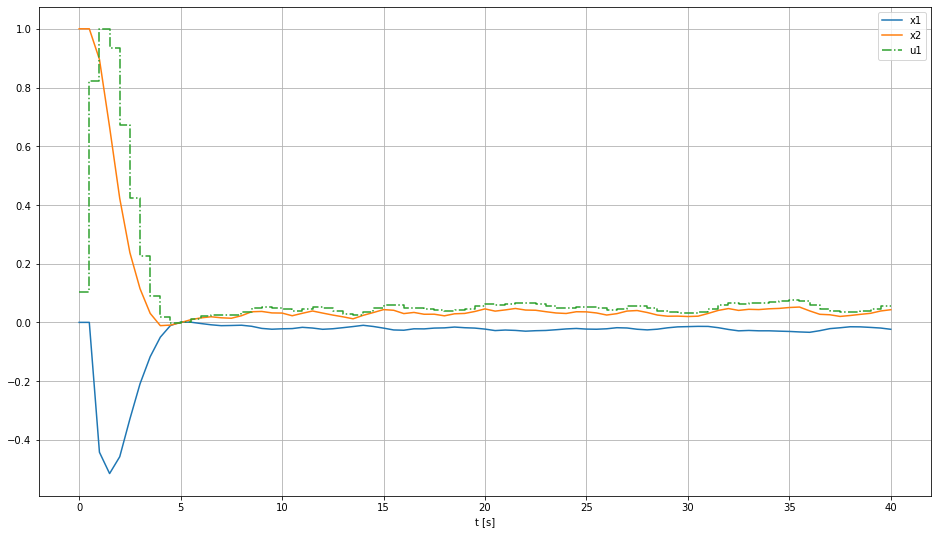

In [43]:
# Plot results!
fig = plt.figure(figsize=(16,9))
tgrid_mpc = np.linspace(0,4*T,4*N+1)
plt.plot(tgrid_mpc, np.append(x0[0], X_log[0,:]).T, label ='x1')
plt.plot(tgrid_mpc, np.append(x0[1], X_log[1,:]).T, label ='x2')
plt.plot(tgrid_mpc, np.append(U_log, np.NaN).T, linestyle='-.', drawstyle='steps-post', label="u1")
plt.xlabel('t [s]')
plt.grid(True)
plt.legend()

If you want to save the MPC controller, i.e. the M function for later use, you can do it!

In [225]:
M.save('M.casadi')
M2 = Function.load('M.casadi')
DM.set_precision(15)
print(M(x0))
print(M2(x0))

MESSAGE(sqpmethod): Convergence achieved after 4 iterations
0.101897523198779
MESSAGE(sqpmethod): Convergence achieved after 4 iterations
0.101897523198779
